# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [5]:
df = pd.read_csv('bikes_rent.csv')

df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

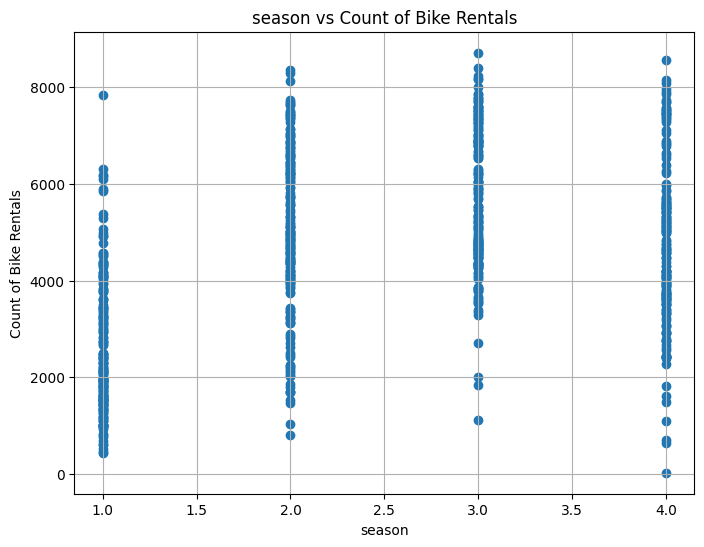

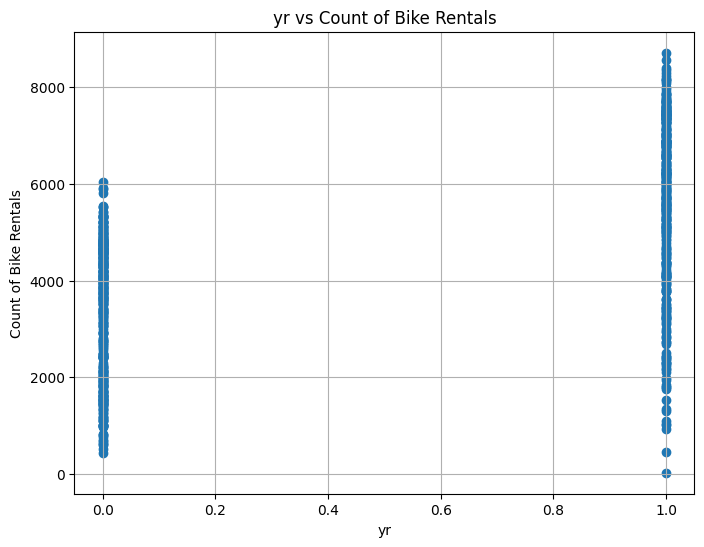

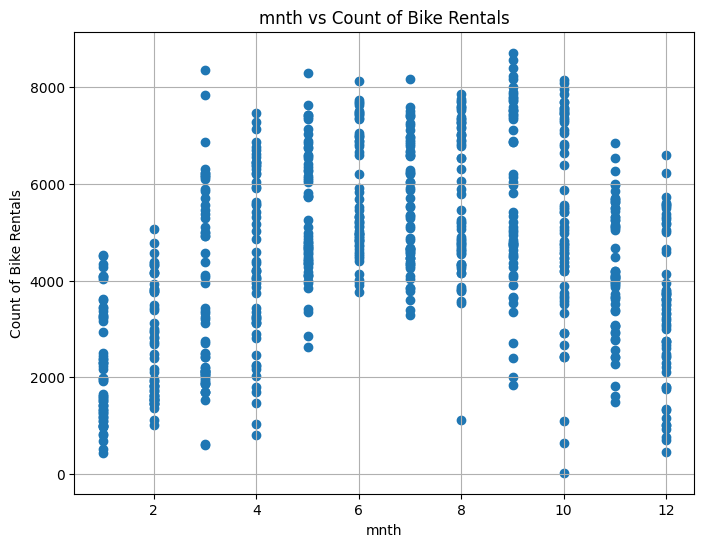

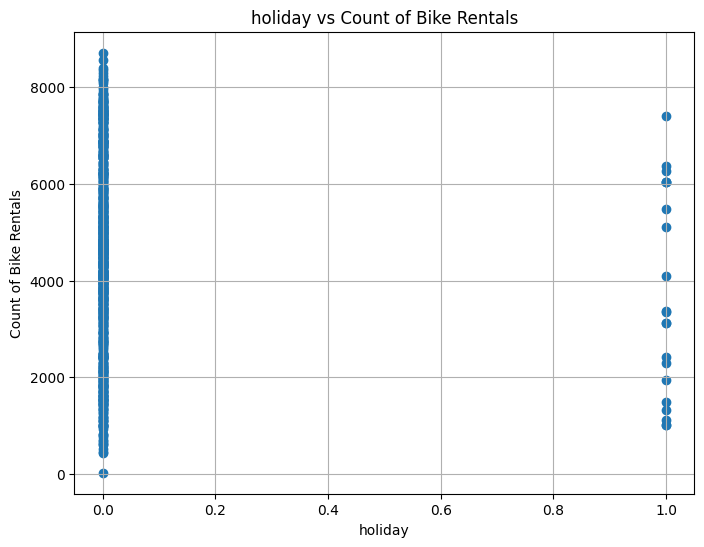

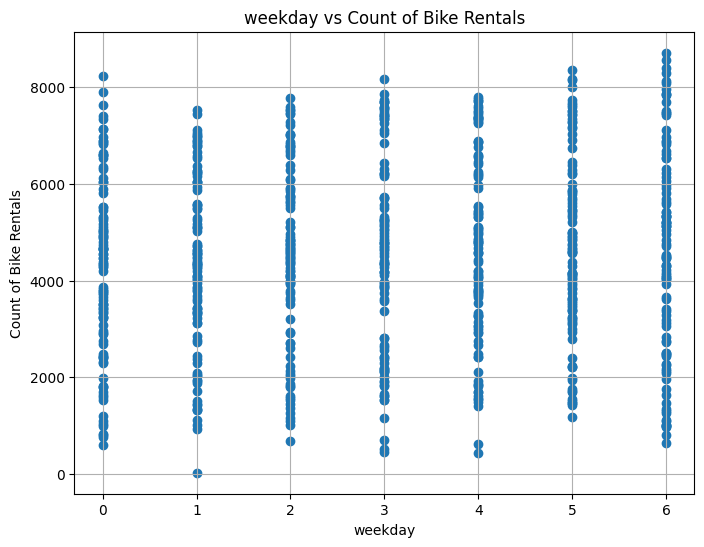

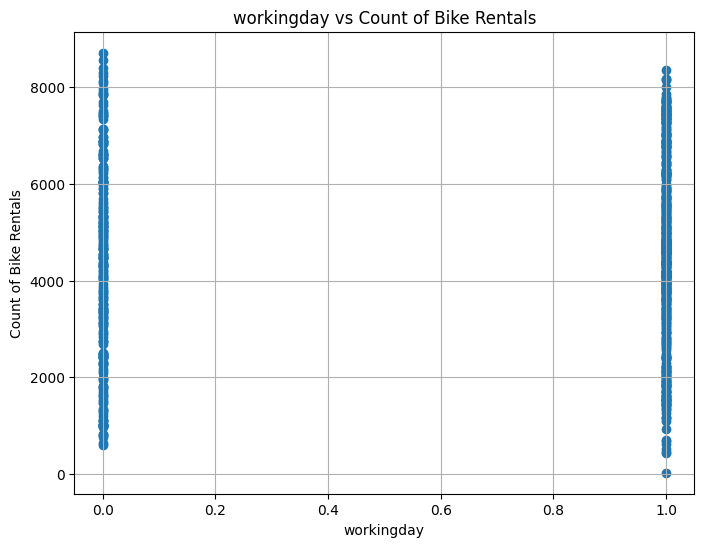

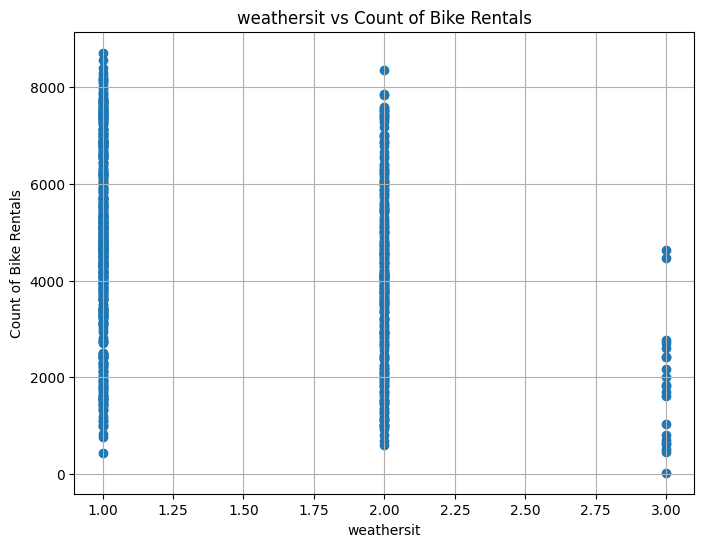

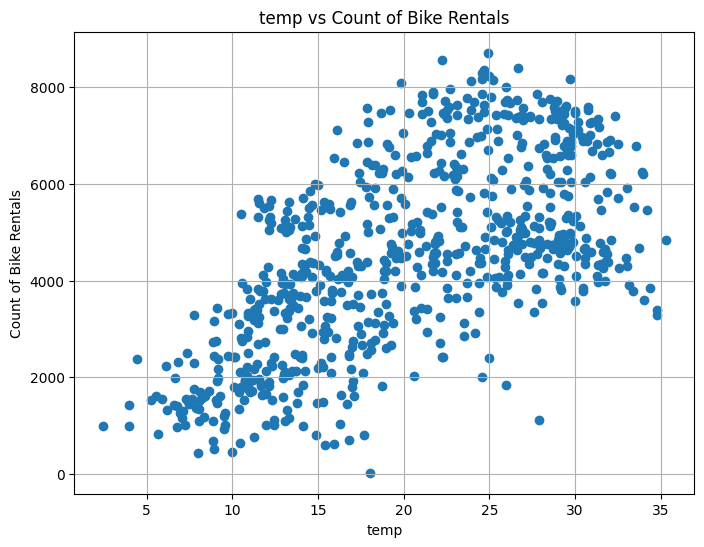

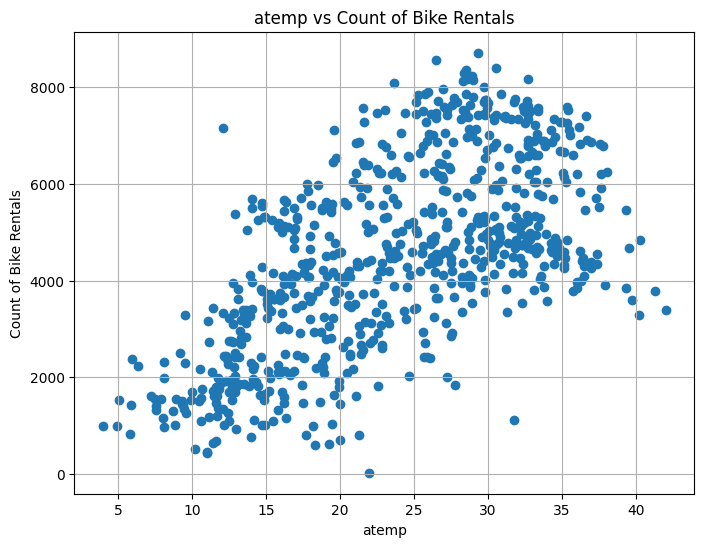

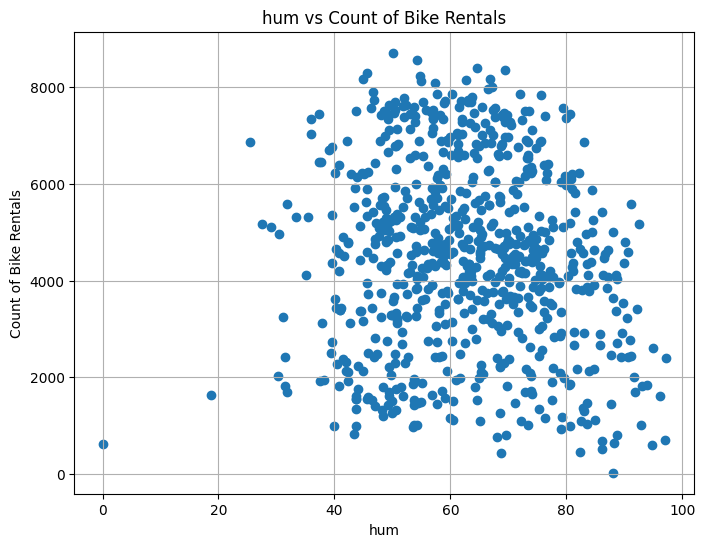

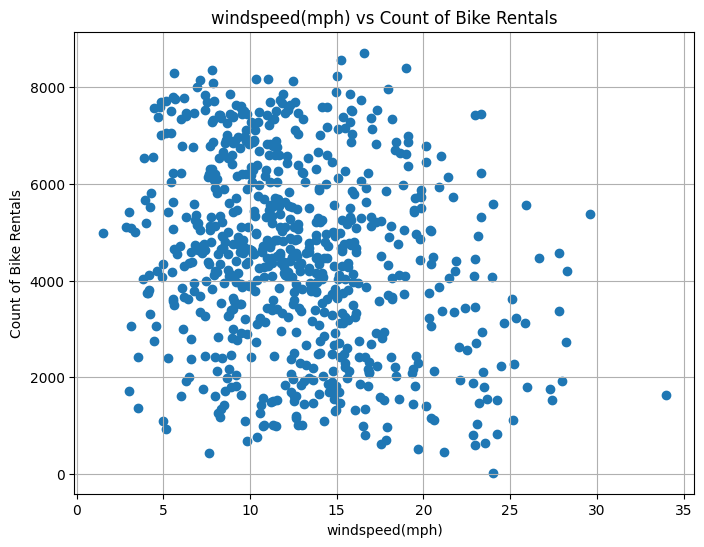

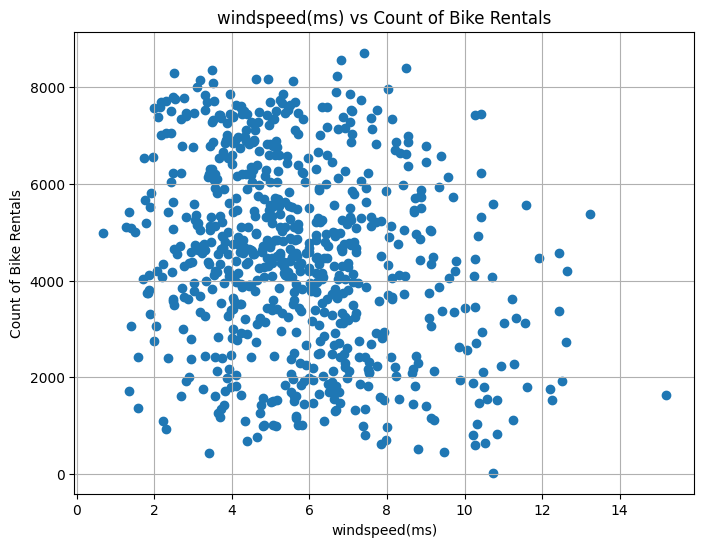

In [6]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

for attribute in attributes:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[attribute], df['cnt'])
    plt.title(f'{attribute} vs Count of Bike Rentals')
    plt.xlabel(attribute)
    plt.ylabel('Count of Bike Rentals')
    plt.grid(True)
    plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?

  **В начале года (январь-март) количество прокатов низкое.
Весной (апрель-июнь) количество прокатов начинает увеличиваться.
Летом (июль-август) наблюдается пиковое количество прокатов.
Осенью (сентябрь-ноябрь) количество прокатов постепенно снижается.
Зимой (декабрь) количество прокатов снова снижается.**

1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно:

 **"temp", "atemp".**

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [7]:
correlations = df.iloc[:, :-2].corrwith(df['cnt'])
correlation_12 = df['windspeed(ms)'].corr(df['cnt'])

print(correlations)
print(f"windspeed(ms) {correlation_12}")

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
dtype: float64
windspeed(ms) -0.23454499742168927


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [8]:
selected_columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
selected_df = df[selected_columns]

correlation = selected_df.corr()

correlation

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [9]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [10]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [11]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

feature_weights = pd.Series(model.coef_, index=df.columns[:-1])
feature_weights

season            5.708638e+02
yr                1.021965e+03
mnth             -1.413017e+02
holiday          -8.675934e+01
weekday           1.372251e+02
workingday        5.639188e+01
weathersit       -3.302265e+02
temp              3.674837e+02
atemp             5.855494e+02
hum              -1.456143e+02
windspeed(mph)    1.245714e+13
windspeed(ms)    -1.245714e+13
dtype: float64

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [13]:
X = df[df.columns[:-1]]
y = df["cnt"]

model = LinearRegression()
model.fit(X, y)

feature_weights = zip(X.columns, model.coef_)

for feature, weight in feature_weights:
    print(f"feature: {feature} \n weight: {weight}\n")

feature: season 
 weight: 514.2756689772416

feature: yr 
 weight: 2043.9333206099773

feature: mnth 
 weight: -40.96317631503962

feature: holiday 
 weight: -519.3860417173415

feature: weekday 
 weight: 68.49569506058863

feature: workingday 
 weight: 121.29281595858514

feature: weathersit 
 weight: -606.4542679476724

feature: temp 
 weight: 48.994172947818015

feature: atemp 
 weight: 71.9163310082323

feature: hum 
 weight: -10.230641893838651

feature: windspeed(mph) 
 weight: 2400995993962.544

feature: windspeed(ms) 
 weight: -5371028038579.01



Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [14]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_model.fit(X, y)

lasso_weights = zip(X.columns, lasso_model.coef_)

for feature, weight in lasso_weights:
    print(f"feature: {feature} \n weight: {weight}\n")


feature: season 
 weight: 506.5512786498074

feature: yr 
 weight: 2036.2316676979037

feature: mnth 
 weight: -38.07827028932167

feature: holiday 
 weight: -484.65194618654056

feature: weekday 
 weight: 68.93837479133958

feature: workingday 
 weight: 118.4475975866837

feature: weathersit 
 weight: -604.5667118927049

feature: temp 
 weight: 51.363260585616366

feature: atemp 
 weight: 69.91273749012187

feature: hum 
 weight: -10.352705204636573

feature: windspeed(mph) 
 weight: -38.34106761310847

feature: windspeed(ms) 
 weight: -0.0



Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [15]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X, y)

ridge_weights = zip(X.columns, ridge_model.coef_)

for feature, weight in ridge_weights:
    print(f"feature: {feature} \n weight: {weight}\n")

feature: season 
 weight: 507.8018818505763

feature: yr 
 weight: 2029.0890541970502

feature: mnth 
 weight: -38.470897279124635

feature: holiday 
 weight: -493.2780154838191

feature: weekday 
 weight: 69.11396965165964

feature: workingday 
 weight: 121.5244250292943

feature: weathersit 
 weight: -605.205555373153

feature: temp 
 weight: 49.31676759598743

feature: atemp 
 weight: 71.7859872733456

feature: hum 
 weight: -10.383394500484615

feature: windspeed(mph) 
 weight: -31.93550169428455

feature: windspeed(ms) 
 weight: -14.276040263842843



### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [16]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    ridge_model = Ridge(alpha=alpha)

    lasso_model.fit(X, y)
    ridge_model.fit(X, y)

    coefs_lasso.append(lasso_model.coef_)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Lasso:")
print(coefs_lasso)

print("Ridge:")
print(coefs_ridge)

Lasso:
[[ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
     0.         -291.33521188   44.34993053   83.88557181  -18.81320743
   -43.35682101   -0.        ]
 [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
     0.           -0.           37.46764176   95.93389064  -26.48659474
   -48.19495616   -0.        ]
 [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
     0.           -0.           33.15169023  102.54337981  -26.88669007
   -47.85305889   -0.        ]
 [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
     0.           -0.           27.55035178  110.33369233  -27.29091458
   -47.46769509   -0.        ]
 [   0.          994.19323854   73.37527257   -0.            0.
     0.           -0.           21.70631423  117.8227646

Проанализируйте динамику весов при увеличении параметра регуляризации:

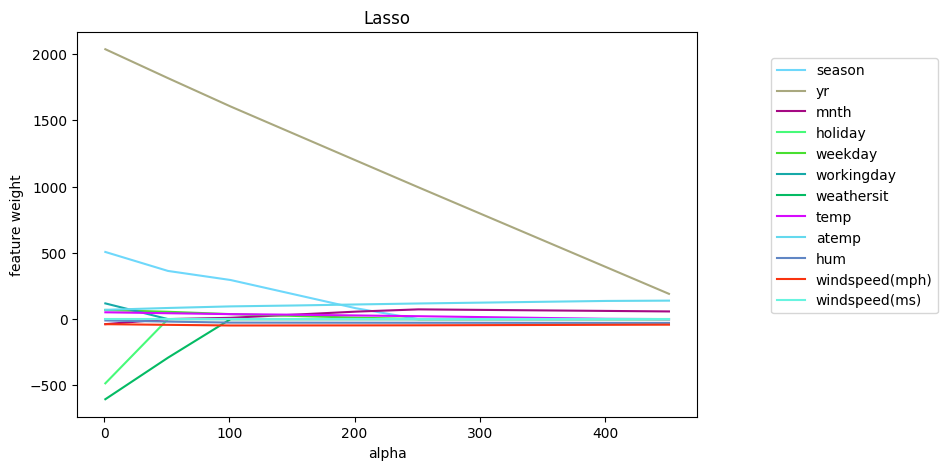

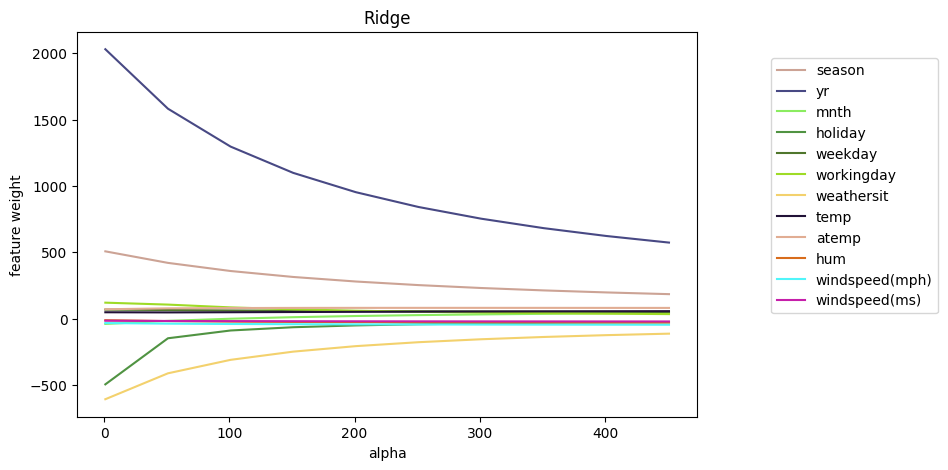

In [17]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
**Lasso агрессивнее уменьшает веса при одном и том же значении alpha. Это видно на графиках, где веса при многих признаках быстро становятся нулевыми при увеличении alpha, в то время как у Ridge веса уменьшаются, но не достигают нуля до очень больших значений alpha.**
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
**Если alpha сделать очень большим, то веса при всех признаках Lasso будут стремиться к нулю. Это происходит потому, что Lasso добавляет штраф к сумме абсолютных значений весов (L1-регуляризация). При большом значении alpha этот штраф становится доминирующим, и модель стремится минимизировать сумму абсолютных значений весов, что приводит к обнулению весов для многих признаков.**
3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
**Да, Lasso исключает один из признаков windspeed при любом значении alpha > 0. Это видно на графике, где вес этого признака быстро уменьшается и становится нулевым.
Ridge не исключает признаки полностью, даже при больших значениях alpha. Он только уменьшает веса, но не обнуляет их.**
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
**Lasso подходит для отбора неинформативных признаков, так как он обнуляет веса при многих признаках, что позволяет выделить наиболее важные признаки. Ridge склонен уменьшать веса, но не обнуляет их, поэтому он может сохранять признаки, которые могли бы быть неинформативными.**

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [18]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

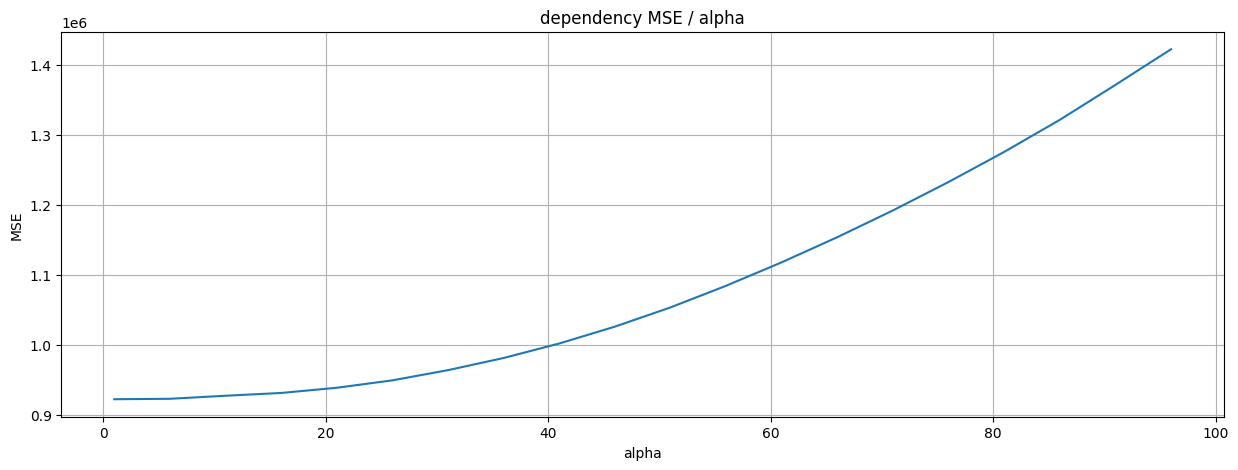

alpha: 1
feature - coefficient:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0


In [21]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)

mse_values = np.mean(regressor.mse_path_, axis=1)
alpha_values = regressor.alphas_
mse_alpha = list(zip(alpha_values, mse_values))

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

create_plot(mse_alpha, "dependency MSE / alpha", "alpha", "MSE")

selected_alpha = regressor.alpha_
coefficients = list(zip(df.columns[:-1], regressor.coef_))

print(f"alpha: {selected_alpha}")
print("feature - coefficient:")
for feature, coefficient in coefficients:
    print(f"{feature}: {coefficient}")


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


alpha: 1 - MSE: 1079704.8011888978
alpha: 51 - MSE: 647591.4582506156
alpha: 1 - MSE: 1542587.5861192632


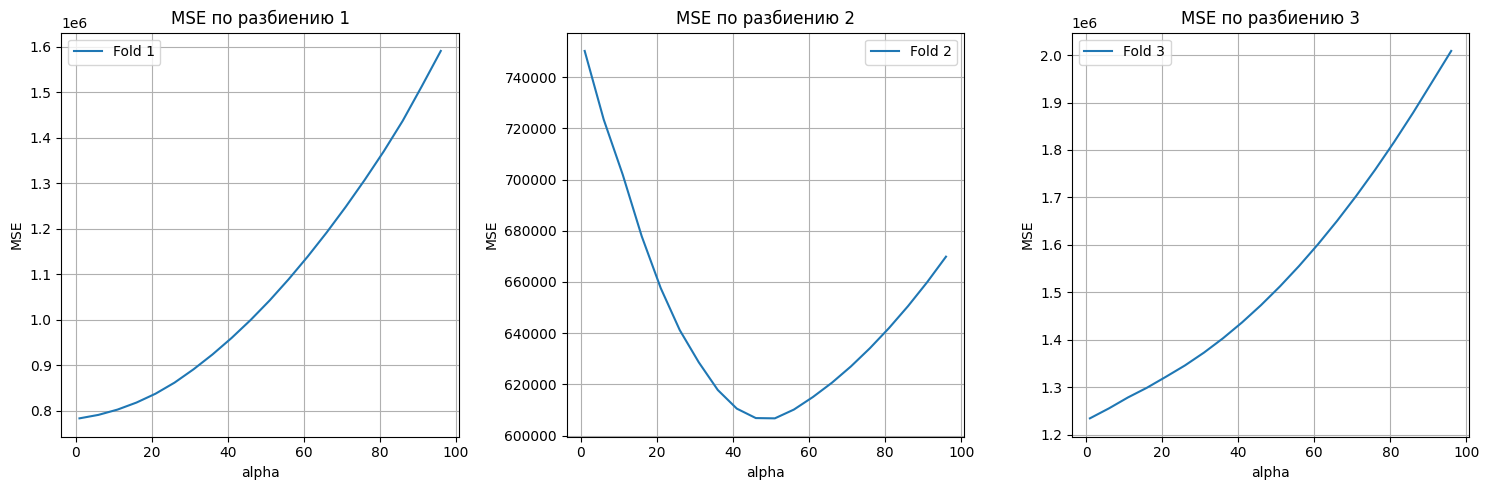

In [35]:
min_alpha_per_fold = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
mse_values = np.mean(regressor.mse_path_, axis=0)

for alpha, mse in zip(min_alpha_per_fold, mse_values):
    print(f"alpha: {alpha} - MSE: {mse}")

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f"Fold {i+1}")
    plt.xlabel("alpha")
    plt.ylabel("MSE")
    plt.title(f"MSE по разбиению {i+1}")
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

yr: 2036.2316676979037
season: 506.5512786498074
workingday: 118.4475975866837
atemp: 69.91273749012187


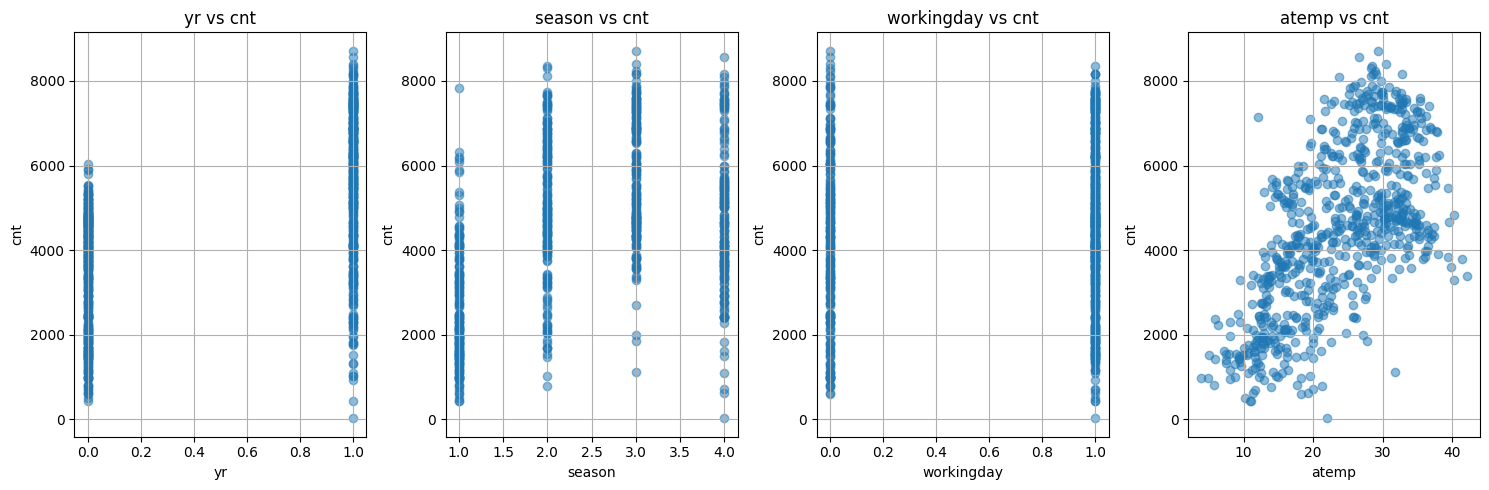

In [36]:
coefficients = regressor.coef_
feature_names = df.columns[:-1]

top_positive_features = [(feature, coef) for feature, coef in zip(feature_names, coefficients) if coef > 0]
top_positive_features.sort(key=lambda x: -x[1])
top_positive_features = top_positive_features[:4]

for feature, coef in top_positive_features:
    print(f"{feature}: {coef}")

plt.figure(figsize=(15, 5))
for i, (feature, _) in enumerate(top_positive_features):
    plt.subplot(1, 4, i + 1)
    plt.scatter(df[feature], df["cnt"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("cnt")
    plt.title(f"{feature} vs cnt")
    plt.grid()

plt.tight_layout()
plt.show()


**Да. На графиках видна положительная линейная зависимость между признаками и cnt. Это гооврит о том, что при увеличении значений этих признаков увеличивается число арендованных велосипедов.**

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

weathersit: -604.5667118927049
holiday: -484.65194618654056
windspeed(mph): -38.34106761310847


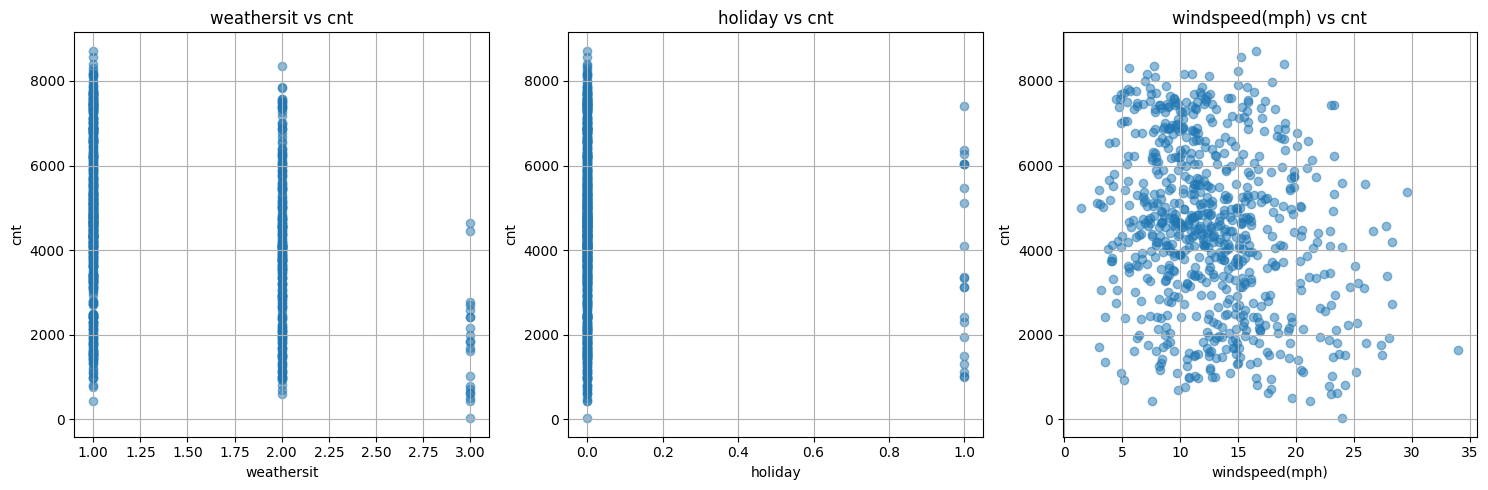

In [37]:
coefficients = regressor.coef_
feature_names = df.columns[:-1]

top_negative_features = [(feature, coef) for feature, coef in zip(feature_names, coefficients) if coef < 0]
top_negative_features.sort(key=lambda x: abs(x[1]), reverse=True)
top_negative_features = top_negative_features[:3]

for feature, coef in top_negative_features:
    print(f"{feature}: {coef}")

plt.figure(figsize=(15, 5))
for i, (feature, _) in enumerate(top_negative_features):
    plt.subplot(1, 3, i + 1)
    plt.scatter(df[feature], df["cnt"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("cnt")
    plt.title(f"{feature} vs cnt")
    plt.grid()

plt.tight_layout()
plt.show()

**Да. На графиках видна отрицательная линейная зависимость между признаками и cnt. Это говорит о том, что при увеличении значений этих признаков уменьшается число арендованных велосипедов.**

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [38]:
near_zero_coefficient_features = [(feature, coef) for feature, coef in zip(feature_names, coefficients) if abs(coef) < 1e-3]

for feature, coef in near_zero_coefficient_features:
    print(f"{feature}: {coef}")

windspeed(ms): -0.0


 **Нет. Модель исключила эти признаки из модели, вероятно, потому что они слабо влияют на спрос на велосипеды и не дают значительного вклада в предсказание. Графики зависимости cnt от этих признаков показывают низкую линейную зависимость или отсутствие её, что может подтверждать их незначимость для объяснения колебаний в спросе на велосипеды.**

**Однако, наличие нулевых или близких к нулю коэффициентов не обязательно означает, что признаки абсолютно не влияют на спрос на велосипеды. Возможно, они вносят некоторый шум или имеют слабую нелинейную зависимость, которую линейная модель не способна захватить.**

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.